In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Adjusting the Anomaly Detection Process

This notebook explores methods to improve anomaly detection by refining the detection process. TimeGPT leverages its forecasting capabilities to identify anomalies based on forecast errors. By optimizing forecast parameters and accuracy, you can align anomaly detection with specific use cases and improve its accuracy.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/capabilities/online-anomaly-detection/02_adjusting_detection_process')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/capabilities/online-anomaly-detection/02_adjusting_detection_process.ipynb)

In [ ]:
import pandas as pd
from nixtla import NixtlaClient
import matplotlib.pyplot as plt

In [ ]:
# Utility function to plot anomalies
def plot_anomaly(df, anomaly_df, time_col = 'ts', target_col = 'y'):
    merged_df = pd.merge(df.tail(300), anomaly_df[[time_col, 'anomaly', 'TimeGPT']], on=time_col, how='left')
    plt.figure(figsize=(12, 2))
    plt.plot(merged_df[time_col], merged_df[target_col], label='y', color='navy', alpha=0.8)
    plt.plot(merged_df[time_col], merged_df['TimeGPT'], label='TimeGPT', color='orchid', alpha=0.7)
    plt.scatter(merged_df.loc[merged_df['anomaly'] == True, time_col], merged_df.loc[merged_df['anomaly'] == True, target_col], color='orchid', label='Anomalies Detected')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, set the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 1. Conduct anomaly detection
After initializing an instance of `NixtlaClient`, let’s explore an example using the Peyton Manning dataset.

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/peyton-manning.csv',parse_dates = ['ds']).tail(200)
df.head()

,unique_id,ds,y
2764,0,2015-07-05,6.499787
2765,0,2015-07-06,6.859615
2766,0,2015-07-07,6.881411
2767,0,2015-07-08,6.997596
2768,0,2015-07-09,7.152269


First, let's set a baseline by using only the default parameters of the method.

In [ ]:
# Base case for anomaly detection using detect_anomaly_online
anomaly_df = nixtla_client.detect_anomalies_online(
    df,
    freq='D',
    h=14,
    level=80,
    detection_size=150
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


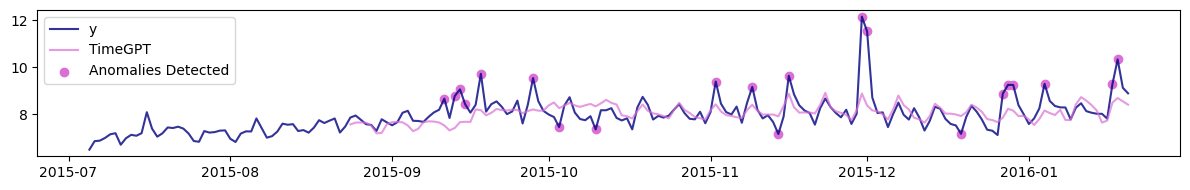

In [ ]:
plot_anomaly(df, anomaly_df, time_col = 'ds', target_col = 'y')

## 2. Adjusting the Anomaly Detection Process
This section explores two key approaches to enhancing anomaly detection: 

1. fine-tuning the model to boost forecast accuracy
2. adjusting forecast horizon and step sizes to optimize time series segmentation and analysis. 

These strategies allow for a more tailored and effective anomaly detection process.

### 2.1 Fine-tune TimeGPT
TimeGPT uses forecast errors for anomaly detection, so improving forecast accuracy reduces noise in the errors, leading to better anomaly detection. You can fine-tune the model using the following parameters:

* `finetune_steps`: Number of steps for finetuning TimeGPT on new data.
* `finetune_depth`: Level of fine-tuning controlling the quantity of parameters being fine-tuned (see our [in-depth tutorial](https://docs.nixtla.io/docs/tutorials-controlling_the_level_of_fine_tuning))
* `finetune_loss`: Loss function to be used during the fine-tuning process.

In [ ]:
anomaly_online_ft = nixtla_client.detect_anomalies_online(
    df,
    freq='D',
    h=14,
    level=80,
    detection_size=150,
    finetune_steps = 10,    # Number of steps for fine-tuning TimeGPT on new data
    finetune_depth = 2,     # Intensity of finetuning
    finetune_loss = 'mae'   # Loss function used during the finetuning process
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


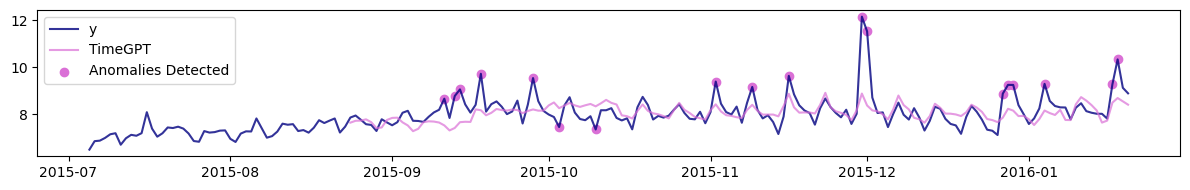

In [ ]:
plot_anomaly(df, anomaly_online_ft, time_col = 'ds', target_col = 'y')

From the plot above, we can see that fewer anomalies were detected by the model, since the fine-tuning process helps TimeGPT better forecast the series.

### 2.2 Change forecast horizon and step
Similar to cross-validation, the anomaly detection method generates forecasts for historical data by splitting the time series into multiple windows. The way these windows are defined can impact the anomaly detection results. Two key parameters control this process:

* `h`: Specifies how many steps into the future the forecast is made for each window.
* `step_size`: Determines the interval between the starting points of consecutive windows.

Note that when `step_size` is smaller than `h`, then we get overlapping windows. This can make the detection process more robust, as TimeGPT will see the same time step more than once. However, this comes with a computational cost, since the same time step will be predicted more than once.

In [ ]:
anomaly_df_horizon = nixtla_client.detect_anomalies_online(
    df,
    time_col='ds',
    target_col='y',
    freq='D',
    h=2,                 # Forecast horizon
    step_size = 1,       # Step size for moving through the time series data
    level=80,            
    detection_size=150
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


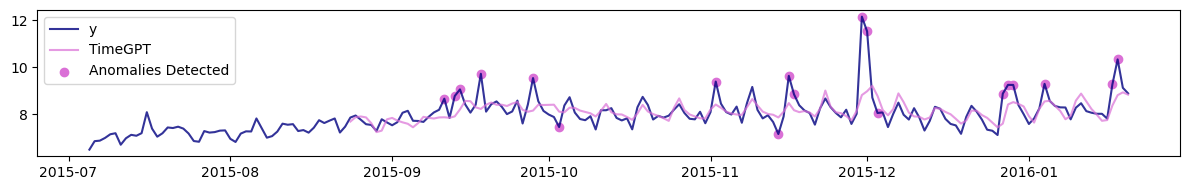

In [ ]:
plot_anomaly(df, anomaly_df_horizon, time_col = 'ds', target_col = 'y')

> 📘 **Balancing h and step_size depends on your data:** For frequent, short-lived anomalies, use a smaller `h` to focus on short-term predictions and a smaller `step_size` to increase overlap and sensitivity. For smooth trends or long-term patterns, use a larger `h` to capture broader anomalies and a larger `step_size` to reduce noise and computational cost.